### **Importing the packages and libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,DenseNet201,ResNet50,VGG19,Xception,InceptionResNetV2
from tensorflow.keras.layers import AveragePooling2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os

Using TensorFlow backend.


In [2]:
if tf.test.gpu_device_name():
  print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
  print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
train_path='/content/drive/My Drive/covid-chestxray-dataset-master/covid-chestxray-dataset-master/DATA/train'
test_path='/content/drive/My Drive/covid-chestxray-dataset-master/covid-chestxray-dataset-master/DATA/test'

In [4]:
BS = 2
train_datagen=ImageDataGenerator(rescale=1./255,fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(directory=train_path,target_size=(224,224),class_mode="categorical",batch_size=BS,shuffle=True,seed=42)
# val_generator=train_datagen.flow_from_directory(directory=train_path,target_size=(224,224),class_mode="categorical",batch_size=BS,subset='validation')

Found 80 images belonging to 2 classes.


In [5]:
test_batches=ImageDataGenerator(rescale=1./255,fill_mode='nearest').flow_from_directory(directory=test_path,target_size=(224,224),class_mode="categorical",batch_size=BS,seed=42,shuffle=False)

Found 20 images belonging to 2 classes.


In [10]:
#RANDOM INITIALIZATION OF WEIGHTS
# class_weight = {
#     0:0.85,
#     1:0.15
# }

In [13]:
imgs,labels=next(train_generator)

In [7]:
def plot_img(img_arr):
  fig,axes=plt.subplots(1,2,figsize=(10,10))
  axes=axes.flatten()
  for img,ax in zip(img_arr,axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

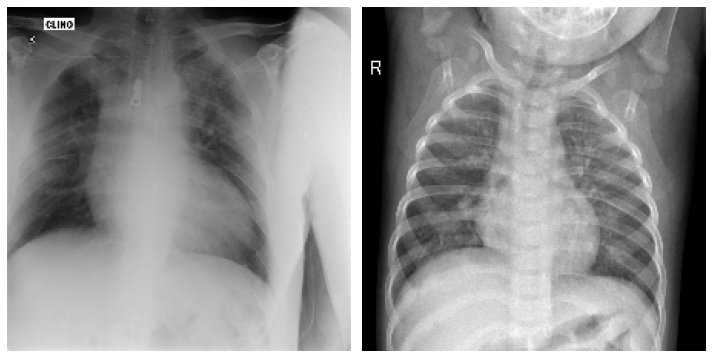

[[1. 0.]
 [0. 1.]]


In [14]:
plot_img(imgs)
print(labels)

###ResNet50

In [16]:
INIT_LR = 1e-5
EPOCHS = 30
BS = 2
k_fold=3
cv_scores, model_history = list(), list()
for i in range(k_fold):
  print("K-FOLD:",i+1)
  baseModel = ResNet50(include_top=False,weights='imagenet',input_tensor=Input(shape=(224, 224, 3)))

  headModel = baseModel.output

  headModel=GlobalAveragePooling2D()(headModel)

  headModel=Dense(1024,activation='relu')(headModel)
  # headModel=Dense(256,activation='relu')(headModel)
  headModel = Dense(2, activation="softmax")(headModel)

  model = Model(inputs=baseModel.input, outputs=headModel)

  print("[INFO] compiling model...")
  opt = Adam(lr=INIT_LR)
  model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


  print("[INFO] training head...")
  H = model.fit(x=train_generator,batch_size=BS,epochs=EPOCHS,verbose=2)
  predictions=model.predict(test_batches)
  predIdxs = np.argmax(predictions, axis=1)
  cm=confusion_matrix(y_true=test_batches.classes,y_pred=predIdxs)
  print(cm)
  print(classification_report(test_batches.classes,predIdxs))
  total = sum(sum(cm))
  acc = (cm[0, 0] + cm[1, 1]) / total
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
  specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
  # show the confusion matrix, accuracy, sensitivity, and specificity
  print(cm)
  print("acc: {:.4f}".format(acc))
  print("sensitivity: {:.4f}".format(sensitivity))
  print("specificity: {:.4f}".format(specificity))

  cv_scores.append(acc)
  model_history.append(H.history)

print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

K-FOLD: 1
[INFO] compiling model...
[INFO] training head...
Epoch 1/30
40/40 - 3s - loss: 0.6115 - accuracy: 0.6625
Epoch 2/30
40/40 - 3s - loss: 0.2837 - accuracy: 0.9375
Epoch 3/30
40/40 - 3s - loss: 0.1672 - accuracy: 0.9750
Epoch 4/30
40/40 - 3s - loss: 0.1343 - accuracy: 0.9750
Epoch 5/30
40/40 - 3s - loss: 0.1443 - accuracy: 0.9750
Epoch 6/30
40/40 - 3s - loss: 0.0944 - accuracy: 0.9875
Epoch 7/30
40/40 - 3s - loss: 0.0906 - accuracy: 1.0000
Epoch 8/30
40/40 - 3s - loss: 0.0797 - accuracy: 1.0000
Epoch 9/30
40/40 - 3s - loss: 0.0453 - accuracy: 1.0000
Epoch 10/30
40/40 - 3s - loss: 0.0337 - accuracy: 1.0000
Epoch 11/30
40/40 - 3s - loss: 0.0293 - accuracy: 1.0000
Epoch 12/30
40/40 - 3s - loss: 0.0332 - accuracy: 1.0000
Epoch 13/30
40/40 - 3s - loss: 0.0258 - accuracy: 1.0000
Epoch 14/30
40/40 - 3s - loss: 0.0222 - accuracy: 1.0000
Epoch 15/30
40/40 - 3s - loss: 0.0189 - accuracy: 1.0000
Epoch 16/30
40/40 - 3s - loss: 0.0100 - accuracy: 1.0000
Epoch 17/30
40/40 - 3s - loss: 0.0121

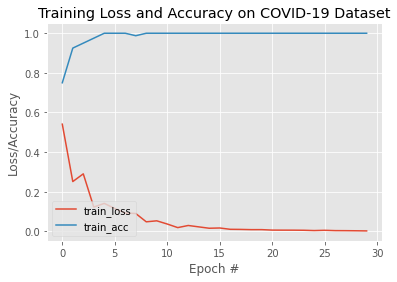

In [17]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

###VGG19

In [18]:
INIT_LR = 1e-5
EPOCHS = 30
BS = 2
k_fold=3
cv_scores, model_history = list(), list()
for i in range(k_fold):
  print("K-FOLD:",i+1)
  baseModel = VGG19(include_top=False,weights='imagenet',input_tensor=Input(shape=(224, 224, 3)))

 

  headModel = baseModel.output
  headModel=GlobalAveragePooling2D()(headModel)
  headModel=Dense(1024,activation='relu')(headModel)
  headModel = Dense(2, activation="softmax")(headModel)

  model = Model(inputs=baseModel.input, outputs=headModel)

  print("[INFO] compiling model...")
  opt = Adam(lr=INIT_LR)
  model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


  print("[INFO] training head...")
  H = model.fit(x=train_generator,batch_size=BS,epochs=EPOCHS,verbose=2)
  predictions=model.predict(test_batches)
  predIdxs = np.argmax(predictions, axis=1)
  cm=confusion_matrix(y_true=test_batches.classes,y_pred=predIdxs)
  print(cm)
  print(classification_report(test_batches.classes,predIdxs))
  total = sum(sum(cm))
  acc = (cm[0, 0] + cm[1, 1]) / total
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
  specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
  # show the confusion matrix, accuracy, sensitivity, and specificity
  print(cm)
  print("acc: {:.4f}".format(acc))
  print("sensitivity: {:.4f}".format(sensitivity))
  print("specificity: {:.4f}".format(specificity))
  cv_scores.append(acc)
  model_history.append(H.history)

print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

K-FOLD: 1
[INFO] compiling model...
[INFO] training head...
Epoch 1/30
40/40 - 3s - loss: 0.3692 - accuracy: 0.9250
Epoch 2/30
40/40 - 3s - loss: 0.0807 - accuracy: 0.9750
Epoch 3/30
40/40 - 3s - loss: 0.0122 - accuracy: 1.0000
Epoch 4/30
40/40 - 3s - loss: 0.0011 - accuracy: 1.0000
Epoch 5/30
40/40 - 3s - loss: 6.2443e-04 - accuracy: 1.0000
Epoch 6/30
40/40 - 3s - loss: 4.0168e-04 - accuracy: 1.0000
Epoch 7/30
40/40 - 3s - loss: 2.7095e-04 - accuracy: 1.0000
Epoch 8/30
40/40 - 3s - loss: 1.9448e-04 - accuracy: 1.0000
Epoch 9/30
40/40 - 3s - loss: 1.4396e-04 - accuracy: 1.0000
Epoch 10/30
40/40 - 3s - loss: 1.0627e-04 - accuracy: 1.0000
Epoch 11/30
40/40 - 3s - loss: 8.3370e-05 - accuracy: 1.0000
Epoch 12/30
40/40 - 3s - loss: 6.5558e-05 - accuracy: 1.0000
Epoch 13/30
40/40 - 3s - loss: 5.2219e-05 - accuracy: 1.0000
Epoch 14/30
40/40 - 3s - loss: 4.3459e-05 - accuracy: 1.0000
Epoch 15/30
40/40 - 3s - loss: 3.6450e-05 - accuracy: 1.0000
Epoch 16/30
40/40 - 3s - loss: 3.0416e-05 - accura

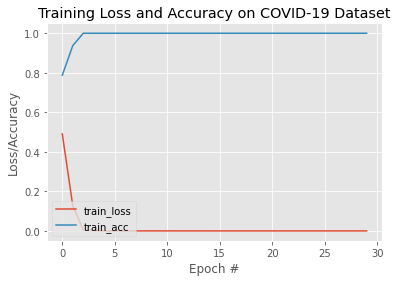

In [19]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

###VGG16

In [20]:
INIT_LR = 1e-5
EPOCHS = 30
BS = 2
k_fold=3
cv_scores, model_history = list(), list()
for i in range(k_fold):
  print("K-FOLD:",i+1)
  baseModel = VGG16(include_top=False,weights='imagenet',input_tensor=Input(shape=(224, 224, 3)))
  
 

  headModel = baseModel.output

  headModel=GlobalAveragePooling2D()(headModel)
  
  headModel=Dense(1024,activation='relu')(headModel)
  headModel = Dense(2, activation="softmax")(headModel)

  model = Model(inputs=baseModel.input, outputs=headModel)

  print("[INFO] compiling model...")
  opt = Adam(lr=INIT_LR)
  model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


  print("[INFO] training head...")
  H = model.fit(x=train_generator,batch_size=BS,epochs=EPOCHS,verbose=2)
  predictions=model.predict(test_batches)
  predIdxs = np.argmax(predictions, axis=1)
  cm=confusion_matrix(y_true=test_batches.classes,y_pred=predIdxs)
  print(cm)
  print(classification_report(test_batches.classes,predIdxs))
  total = sum(sum(cm))
  acc = (cm[0, 0] + cm[1, 1]) / total
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
  specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
  # show the confusion matrix, accuracy, sensitivity, and specificity
  print(cm)
  print("acc: {:.4f}".format(acc))
  print("sensitivity: {:.4f}".format(sensitivity))
  print("specificity: {:.4f}".format(specificity))
  cv_scores.append(acc)
  model_history.append(H.history)

print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

K-FOLD: 1
58892288/58889256 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/30
40/40 - 3s - loss: 0.5672 - accuracy: 0.7250
Epoch 2/30
40/40 - 3s - loss: 0.2011 - accuracy: 0.9375
Epoch 3/30
40/40 - 3s - loss: 0.0386 - accuracy: 0.9875
Epoch 4/30
40/40 - 3s - loss: 0.0449 - accuracy: 0.9875
Epoch 5/30
40/40 - 3s - loss: 0.0022 - accuracy: 1.0000
Epoch 6/30
40/40 - 3s - loss: 8.4989e-04 - accuracy: 1.0000
Epoch 7/30
40/40 - 3s - loss: 6.0809e-04 - accuracy: 1.0000
Epoch 8/30
40/40 - 3s - loss: 3.9891e-04 - accuracy: 1.0000
Epoch 9/30
40/40 - 3s - loss: 2.9753e-04 - accuracy: 1.0000
Epoch 10/30
40/40 - 3s - loss: 2.3570e-04 - accuracy: 1.0000
Epoch 11/30
40/40 - 3s - loss: 1.9469e-04 - accuracy: 1.0000
Epoch 12/30
40/40 - 3s - loss: 1.5475e-04 - accuracy: 1.0000
Epoch 13/30
40/40 - 3s - loss: 1.3279e-04 - accuracy: 1.0000
Epoch 14/30
40/40 - 3s - loss: 1.0690e-04 - accuracy: 1.0000
Epoch 15/30
40/40 - 3s - loss: 8.8190e-05 - accura

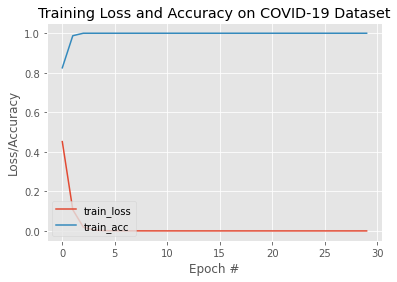

In [21]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

###Xception

In [22]:
INIT_LR = 1e-5
EPOCHS = 30
BS = 2
k_fold=3
cv_scores, model_history = list(), list()
for i in range(k_fold):
  print("K-FOLD:",i+1)
  baseModel = Xception(include_top=False,weights='imagenet',input_tensor=Input(shape=(224, 224, 3)))
  
 

  headModel = baseModel.output
 
  headModel=GlobalAveragePooling2D()(headModel)
  
  headModel=Dense(1024,activation='relu')(headModel)
  headModel = Dense(2, activation="softmax")(headModel)

  model = Model(inputs=baseModel.input, outputs=headModel)

  print("[INFO] compiling model...")
  opt = Adam(lr=INIT_LR)
  model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


  print("[INFO] training head...")
  H = model.fit(x=train_generator,batch_size=BS,epochs=EPOCHS,verbose=2)
  predictions=model.predict(test_batches)
  predIdxs = np.argmax(predictions, axis=1)
  cm=confusion_matrix(y_true=test_batches.classes,y_pred=predIdxs)
  print(cm)
  print(classification_report(test_batches.classes,predIdxs))
  total = sum(sum(cm))
  acc = (cm[0, 0] + cm[1, 1]) / total
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
  specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
  # show the confusion matrix, accuracy, sensitivity, and specificity
  print(cm)
  print("acc: {:.4f}".format(acc))
  print("sensitivity: {:.4f}".format(sensitivity))
  print("specificity: {:.4f}".format(specificity))
  cv_scores.append(acc)
  model_history.append(H.history)

print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

K-FOLD: 1
83689472/83683744 [==============================] - 1s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/30
40/40 - 3s - loss: 0.6702 - accuracy: 0.6125
Epoch 2/30
40/40 - 3s - loss: 0.5987 - accuracy: 0.7250
Epoch 3/30
40/40 - 3s - loss: 0.4687 - accuracy: 0.8125
Epoch 4/30
40/40 - 3s - loss: 0.4993 - accuracy: 0.7125
Epoch 5/30
40/40 - 3s - loss: 0.4385 - accuracy: 0.7875
Epoch 6/30
40/40 - 3s - loss: 0.4009 - accuracy: 0.8125
Epoch 7/30
40/40 - 3s - loss: 0.3604 - accuracy: 0.8125
Epoch 8/30
40/40 - 3s - loss: 0.4121 - accuracy: 0.8250
Epoch 9/30
40/40 - 3s - loss: 0.2884 - accuracy: 0.8875
Epoch 10/30
40/40 - 3s - loss: 0.3073 - accuracy: 0.8500
Epoch 11/30
40/40 - 3s - loss: 0.3171 - accuracy: 0.8875
Epoch 12/30
40/40 - 3s - loss: 0.2696 - accuracy: 0.9625
Epoch 13/30
40/40 - 3s - loss: 0.2355 - accuracy: 0.9250
Epoch 14/30
40/40 - 3s - loss: 0.1652 - accuracy: 0.9625
Epoch 15/30
40/40 - 3s - loss: 0.1526 - accuracy: 0.9750
Epoch 16/30
40/40 - 3s - loss

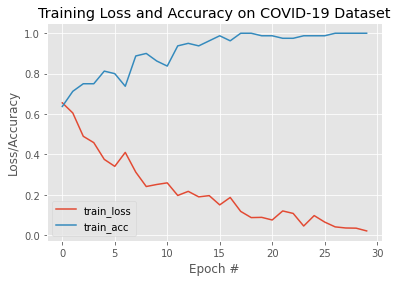

In [23]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

###DenseNet201

In [24]:
INIT_LR = 1e-5
EPOCHS = 30
BS = 2
k_fold=3
cv_scores, model_history = list(), list()
for i in range(k_fold):
  print("K-FOLD:",i+1)
  baseModel = DenseNet201(include_top=False,weights='imagenet',input_tensor=Input(shape=(224, 224, 3)))
  


  headModel = baseModel.output
  
  headModel=GlobalAveragePooling2D()(headModel)
  
  headModel=Dense(1024,activation='relu')(headModel)
  headModel = Dense(2, activation="softmax")(headModel)

  model = Model(inputs=baseModel.input, outputs=headModel)

  print("[INFO] compiling model...")
  opt = Adam(lr=INIT_LR)
  model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


  print("[INFO] training head...")
  H = model.fit(x=train_generator,batch_size=BS,epochs=EPOCHS,verbose=2)
  predictions=model.predict(test_batches)
  predIdxs = np.argmax(predictions, axis=1)
  cm=confusion_matrix(y_true=test_batches.classes,y_pred=predIdxs)
  print(cm)
  print(classification_report(test_batches.classes,predIdxs))
  total = sum(sum(cm))
  acc = (cm[0, 0] + cm[1, 1]) / total
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
  specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
  # show the confusion matrix, accuracy, sensitivity, and specificity
  print(cm)
  print("acc: {:.4f}".format(acc))
  print("sensitivity: {:.4f}".format(sensitivity))
  print("specificity: {:.4f}".format(specificity))
  cv_scores.append(acc)
  model_history.append(H.history)

print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

K-FOLD: 1
74842112/74836368 [==============================] - 2s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/30
40/40 - 5s - loss: 0.6529 - accuracy: 0.5750
Epoch 2/30
40/40 - 5s - loss: 0.3804 - accuracy: 0.8000
Epoch 3/30
40/40 - 5s - loss: 0.3700 - accuracy: 0.7875
Epoch 4/30
40/40 - 5s - loss: 0.3263 - accuracy: 0.8000
Epoch 5/30
40/40 - 5s - loss: 0.2845 - accuracy: 0.8500
Epoch 6/30
40/40 - 5s - loss: 0.3998 - accuracy: 0.8000
Epoch 7/30
40/40 - 5s - loss: 0.2771 - accuracy: 0.8750
Epoch 8/30
40/40 - 5s - loss: 0.3057 - accuracy: 0.8750
Epoch 9/30
40/40 - 5s - loss: 0.2296 - accuracy: 0.9000
Epoch 10/30
40/40 - 5s - loss: 0.1727 - accuracy: 0.9750
Epoch 11/30
40/40 - 5s - loss: 0.3120 - accuracy: 0.9125
Epoch 12/30
40/40 - 5s - loss: 0.2517 - accuracy: 0.9500
Epoch 13/30
40/40 - 5s - loss: 0.2160 - accuracy: 0.9000
Epoch 14/30
40/40 - 5s - loss: 0.2878 - accuracy: 0.8875
Epoch 15/30
40/40 - 5s - loss: 0.1679 - accuracy: 0.9750
Epoch 16/30
40/40 - 5s - loss

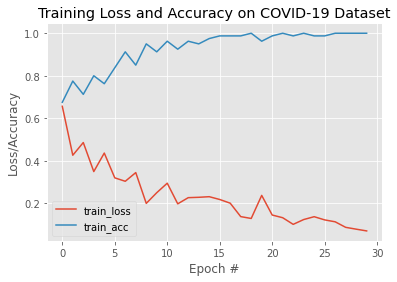

In [25]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

###InceptionResNetV2

In [26]:
INIT_LR = 1e-5
EPOCHS = 30
BS = 2
k_fold=3
cv_scores, model_history = list(), list()
for i in range(k_fold):
  print("K-FOLD:",i+1)
  baseModel = InceptionResNetV2(include_top=False,weights='imagenet',input_tensor=Input(shape=(224, 224, 3)))
  
 

  headModel = baseModel.output
  
  headModel=GlobalAveragePooling2D()(headModel)
  
  headModel=Dense(1024,activation='relu')(headModel)
  headModel = Dense(2, activation="softmax")(headModel)

  model = Model(inputs=baseModel.input, outputs=headModel)

  print("[INFO] compiling model...")
  opt = Adam(lr=INIT_LR)
  model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


  print("[INFO] training head...")
  H = model.fit(x=train_generator,batch_size=BS,epochs=EPOCHS,verbose=2)
  predictions=model.predict(test_batches)
  predIdxs = np.argmax(predictions, axis=1)
  cm=confusion_matrix(y_true=test_batches.classes,y_pred=predIdxs)
  print(cm)
  print(classification_report(test_batches.classes,predIdxs))
  total = sum(sum(cm))
  acc = (cm[0, 0] + cm[1, 1]) / total
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
  specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
  # show the confusion matrix, accuracy, sensitivity, and specificity
  print(cm)
  print("acc: {:.4f}".format(acc))
  print("sensitivity: {:.4f}".format(sensitivity))
  print("specificity: {:.4f}".format(specificity))
  cv_scores.append(acc)
  model_history.append(H.history)

print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

K-FOLD: 1
219062272/219055592 [==============================] - 2s 0us/step
[INFO] compiling model...
[INFO] training head...
Epoch 1/30
40/40 - 5s - loss: 0.6603 - accuracy: 0.6500
Epoch 2/30
40/40 - 5s - loss: 0.5812 - accuracy: 0.7125
Epoch 3/30
40/40 - 5s - loss: 0.4358 - accuracy: 0.8125
Epoch 4/30
40/40 - 5s - loss: 0.4208 - accuracy: 0.7500
Epoch 5/30
40/40 - 5s - loss: 0.4478 - accuracy: 0.7750
Epoch 6/30
40/40 - 5s - loss: 0.3843 - accuracy: 0.7750
Epoch 7/30
40/40 - 5s - loss: 0.3803 - accuracy: 0.7500
Epoch 8/30
40/40 - 6s - loss: 0.3118 - accuracy: 0.8375
Epoch 9/30
40/40 - 5s - loss: 0.3511 - accuracy: 0.8250
Epoch 10/30
40/40 - 5s - loss: 0.3692 - accuracy: 0.7750
Epoch 11/30
40/40 - 5s - loss: 0.3362 - accuracy: 0.8250
Epoch 12/30
40/40 - 6s - loss: 0.3425 - accuracy: 0.8375
Epoch 13/30
40/40 - 5s - loss: 0.3492 - accuracy: 0.8375
Epoch 14/30
40/40 - 5s - loss: 0.2629 - accuracy: 0.9125
Epoch 15/30
40/40 - 6s - loss: 0.2826 - accuracy: 0.9125
Epoch 16/30
40/40 - 6s - lo

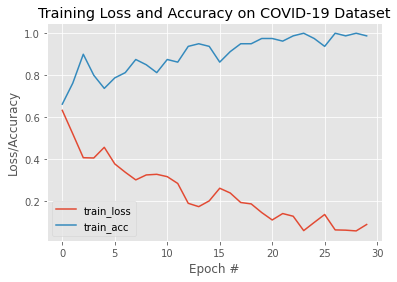

In [27]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")